# Ses Tabanlı Duygu Tanıma (Speech Emotion Recognition - SER)

Bu notebook, **CREMA-D** ve **EMO-DB** veri setlerini kullanarak ses dosyalarından duygu tanıma işlemi gerçekleştirmektedir. Proje aşağıdaki adımları içermektedir:

1.  **Veri Artırma (Data Augmentation):** Ses verilerini zenginleştirmek için gürültü ekleme, hızlandırma, perde kaydırma (pitch shift) gibi teknikler kullanılır.(https://www.researchgate.net/publication/372809586_Speech_emotion_recognition_with_light_gradient_boosting_decision_trees_machine)
2.  **Öznitelik Çıkarma (Feature Extraction):** Ses dosyalarından MFCC, Chroma, Mel Spektrogramı gibi önemli öznitelikler çıkarılır.
3.  **Veri Ön İşleme:** Veri seti eğitim, doğrulama ve test olarak ayrılır. StandardScaler ile ölçeklendirme ve PCA ile boyut indirgeme yapılır.
4.  **Sınıf Dengesizliği:** SMOTE tekniği ile azınlık sınıfları dengelenir.
5.  **Öznitelik Seçimi:** LightGBM kullanılarak en önemli öznitelikler seçilir.
6.  **Modelleme ve Değerlendirme:** **LightGBM**, **SVM** ve **MLP** modelleri eğitilir, değerlendirilir ve karşılaştırılır.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Kütüphanelerin Yüklenmesi ve Ayarlar

In [7]:
# Yerel bir ortamda çalışıyorsanız, terminal/komut isteminde aşağıdaki komutu çalıştırın:
# pip install -U scikit-learn imbalanced-learn pandas numpy librosa matplotlib seaborn lightgbm joblib
%pip install -U scikit-learn imbalanced-learn resampy

  Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)


In [8]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from scipy.stats import loguniform
import joblib
import warnings
import json
import resampy
import gc
from itertools import islice


# Uyarıları gizle
warnings.filterwarnings('ignore')

# Grafikleri notebook içinde göstermek için
%matplotlib inline

In [9]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


## 2. Yardımcı Fonksiyonlar

### 2.1. Ses Artırma (Audio Augmentation)
Veri setindeki çeşitliliği artırmak ve modelin genelleme yeteneğini iyileştirmek için ses dosyalarına çeşitli artırma teknikleri uygulanır.

In [10]:
def augment_audio(y, sr, audio2=None, fixed_length=32000):
    """Ses verisini artırmak için çeşitli teknikler uygular."""
    augmented = []

    # Normalizasyon ve boyutlandırma
    y = y / np.max(np.abs(y)) if np.max(np.abs(y)) != 0 else y
    if len(y) > fixed_length:
        y = y[:fixed_length]
    else:
        y = np.pad(y, (0, fixed_length - len(y)), mode='constant')
    augmented.append(y) # Orijinal ses

    # Gürültü Ekleme (Noise)
    noise = y + 0.005 * np.random.randn(len(y))
    augmented.append(noise)

    # Hız Değiştirme (Time Stretch)
    try:
        speed = librosa.effects.time_stretch(y, rate=1.1)
        if len(speed) > fixed_length:
            speed = speed[:fixed_length]
        else:
            speed = np.pad(speed, (0, fixed_length - len(speed)), mode='constant')
        augmented.append(speed)
    except Exception:
        pass

    # Perde Kaydırma (Pitch Shift)
    try:
        vtlp = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-1, 1))
        if len(vtlp) > fixed_length:
            vtlp = vtlp[:fixed_length]
        else:
            vtlp = np.pad(vtlp, (0, fixed_length - len(vtlp)), mode='constant')
        augmented.append(vtlp)
    except Exception:
        pass
    return augmented

### 2.2. Öznitelik Çıkarma (Feature Extraction)
Her bir ses dosyasından modelin öğrenebileceği sayısal öznitelikler (MFCC, Chroma, Mel vb.) çıkarılır.

In [11]:
def compute_deltas_manual(spectrogram, delta_width=2):
    """Manuel delta hesaplama (GPU)."""
    delta = torch.zeros_like(spectrogram).cuda()
    padded = torch.nn.functional.pad(spectrogram, (delta_width, delta_width), mode='replicate')
    for t in range(spectrogram.shape[1]):
        delta[:, t] = (padded[:, t + delta_width] - padded[:, t]) / (2.0 * delta_width)
    return delta

In [14]:
def extract_features_from_raw(y, sample_rate, mfcc=True, chroma=True, mel=True, zcr=True, centroid=True, energy=True):
    """Ham ses verisinden çeşitli akustik öznitelikler çıkarır."""
    result = np.array([])
    y = y / np.max(np.abs(y)) if np.max(np.abs(y)) != 0 else y

    try:
        if mfcc:
            mfccs = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=10)
            delta_mfccs = librosa.feature.delta(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2)
            mfcc_features = np.vstack((mfccs, delta_mfccs, delta2_mfccs)).T
            result = np.hstack((result, np.mean(mfcc_features, axis=0))) # 30 özellik
        if chroma:
            chroma_val = np.mean(librosa.feature.chroma_stft(y=y, sr=sample_rate, n_chroma=12).T, axis=0)
            result = np.hstack((result, chroma_val)) # 12 özellik
        if mel:
            mel_val = np.mean(librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=16).T, axis=0)
            result = np.hstack((result, mel_val)) # 16 özellik
        if zcr:
            zcr_val = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)
            result = np.hstack((result, zcr_val)) # 1 özellik
        if centroid:
            centroid_val = np.mean(librosa.feature.spectral_centroid(y=y, sr=sample_rate).T, axis=0)
            result = np.hstack((result, centroid_val)) # 1 özellik
        if energy:
            energy_val = np.mean(np.square(y))
            result = np.hstack((result, energy_val)) # 1 özellik
    except Exception as e:
        print(f'Öznitelik çıkarma hatası: {e}')
        return np.zeros(61) # Beklenen öznitelik sayısı

    # Eğer herhangi bir nedenle beklenen boyutta değilse, doldur
    if result.shape[0] != 61:
        return np.zeros(61)

    return result

### 2.3. Veri Yükleme
Belirtilen yoldan ses dosyalarını yükler, her birine data augmentation uygular ve özniteliklerini çıkarır.

#### Büyük veriyi snippetlere ayırmak
Emo-db veri setinde sesler çok uzun olduğu için belleği zorluyor. Bunu aşmak için veriyi snippetlere böldüm.

In [3]:
def load_data(dataset_path, emotion_map, dataset_name, max_per_class=50, fixed_length=32000, use_augmentation=True):
    """Veri setini yükler, artırır (isteğe bağlı) ve öznitelikleri çıkarır."""
    features, labels = [], []
    all_audios = []
    sample_rate = 22050 if dataset_name == 'CREMA-D' else 16000  # EMO-DB için 16 kHz zaten çok daha uzun dosyalar var

    print(f"{dataset_name} veri seti yükleniyor... (Sample Rate: {sample_rate})")
    for emotion_code, emotion_name in emotion_map.items():
        path_pattern = os.path.join(dataset_path, emotion_code, '*.wav')
        files = glob.glob(path_pattern)[:max_per_class]
        if not files:
            print(f"Uyarı: {emotion_code} ({emotion_name}) sınıfında dosya bulunamadı.")
            continue
        print(f"{emotion_name} sınıfı: {len(files)} dosya bulundu.")
        for file_name in files:
            try:
                y, sr = librosa.load(file_name, sr=sample_rate, res_type='kaiser_fast')
                if len(y) == 0:
                    print(f"Uyarı: {file_name} boş veya hatalı.")
                    continue
                # if dataset_name == 'EMO-DB':
                #     # EMO-DB için sesi 2.5 saniyelik parçalara böl
                #     chunks = split_audio(y, sr, chunk_length=2.5)
                #     for chunk in chunks:
                #         all_audios.append((chunk, sr, emotion_name, file_name))
                # else:
                #     # CREMA-D için orijinal ses
                all_audios.append((y, sr, emotion_name, file_name))
            except Exception as e:
                print(f'Hata: {file_name} dosyası işlenemedi. Hata: {str(e)}')

    if not all_audios:
        print(f"Hata: {dataset_name} için hiç ses dosyası yüklenemedi.")
        return np.array([]), np.array([])

    print(f"Öznitelik çıkarma ve augmentation işlemleri yapılıyor... ({len(all_audios)} dosya)" if use_augmentation else f"Öznitelik çıkarma işlemleri yapılıyor... ({len(all_audios)} dosya)")
    for y, sr, emotion_name, file_name in all_audios:
        if dataset_name == 'CREMA-D' and use_augmentation:
            augmented_audios = augment_audio(y, sr, fixed_length=fixed_length)
            if not augmented_audios:
                print(f"Uyarı: {file_name} ({emotion_name}) için augmentation başarısız, orijinal ses kullanılıyor.")
                if len(y) > fixed_length:
                    y = y[:fixed_length]
                else:
                    y = np.pad(y, (0, max(0, fixed_length - len(y))), mode='constant')
                augmented_audios = [y]
        else:
            if len(y) > fixed_length:
                y = y[:fixed_length]
            else:
                y = np.pad(y, (0, max(0, fixed_length - len(y))), mode='constant')
            augmented_audios = [y]

        for audio in augmented_audios:
            try:
                feature_vector = extract_features_from_raw(audio, sr)
                if feature_vector.shape[0] == 61:
                    features.append(feature_vector)
                    labels.append(emotion_name)
                else:
                    print(f"Uyarı: {file_name} ({emotion_name}) için öznitelik boyutu {feature_vector.shape[0]} (beklenen: 61)")
            except Exception as e:
                print(f"Öznitelik çıkarma hatası: {file_name} ({emotion_name}). Hata: {str(e)}")

    if not features:
        print(f"Hata: {dataset_name} için hiç öznitelik çıkarılamadı.")
        return np.array([]), np.array([])

    features = np.array(features, dtype=np.float32)
    labels = np.array(labels)

    valid_indices = [i for i, f in enumerate(features) if f.shape[0] == 61]
    if len(valid_indices) < len(features):
        print(f"Uyarı: {len(features) - len(valid_indices)} hatalı öznitelik vektörü temizlendi.")
    features = features[valid_indices]
    labels = labels[valid_indices]

    print(f"{dataset_name}: Toplam {len(features)} örnek")
    return features, labels


## 3. Veri Seti Hazırlığı
Veri setlerinin yolları, duygu haritaları tanımlanır ve `load_data` fonksiyonu ile veriler yüklenir. Google Colab ortamında çalışıyorsanız, veri setlerinizi yükleyip yolları doğru şekilde ayarlamanız gerekmektedir.

In [12]:
# Veri setleri için duygu haritaları
crema_emotion_map = {
    'HAP': 'Happy',
    'SAD': 'Sad',
    'ANG': 'Angry',
    'FEA': 'Fear',
    'DIS': 'Disgust',
    'NEU': 'Neutral'
}

emodb_emotion_map = {
    'angry': 'Angry',
    'happy': 'Happy',
    'disgusted': 'Disgust',
    'fearful': 'Fear',
    'surprised': 'Surprised',
    'sad': 'Sad',
    'neutral': 'Neutral'
}

# Veri seti yolları (Çalıştırılacak ortama göre düzenlenemeli)
BASE_PATH = './' # Eğer notebook ile aynı dizindeyse
CREMA_D_PATH = os.path.join(BASE_PATH, '/content/drive/MyDrive/AudioEmotionDetection/datasets/CREMA-D')#'datasets/CREMA-D'
EMODB_PATH = os.path.join(BASE_PATH, '/content/drive/MyDrive/AudioEmotionDetection/datasets/EMO-DB')#'datasets/EMO-DB'

In [15]:
crema_features, crema_labels = load_data(CREMA_D_PATH, crema_emotion_map, 'CREMA-D', max_per_class=1500, use_augmentation=False)
print(f'CREMA-D: Toplam {len(crema_features)} adet örnek işlendi.\n')

CREMA-D veri seti yükleniyor... (Sample Rate: 22050)
Happy sınıfı: 1272 dosya bulundu.
Sad sınıfı: 1271 dosya bulundu.
Angry sınıfı: 1271 dosya bulundu.
Fear sınıfı: 1271 dosya bulundu.
Disgust sınıfı: 742 dosya bulundu.
Neutral sınıfı: 1087 dosya bulundu.
Öznitelik çıkarma işlemleri yapılıyor... (6914 dosya)
CREMA-D: Toplam 6914 örnek
CREMA-D: Toplam 6914 adet örnek işlendi.



In [20]:
aug_crema_features, aug_crema_labels = load_data(CREMA_D_PATH, crema_emotion_map, 'CREMA-D', max_per_class=1500, use_augmentation=True)
print(f'CREMA-D: Toplam {len(aug_crema_features)} adet artırılmış örnek işlendi.\n')

CREMA-D veri seti yükleniyor... (Sample Rate: 22050)
Happy sınıfı: 1272 dosya bulundu.
Sad sınıfı: 1271 dosya bulundu.
Angry sınıfı: 1271 dosya bulundu.
Fear sınıfı: 1271 dosya bulundu.
Disgust sınıfı: 742 dosya bulundu.
Neutral sınıfı: 1087 dosya bulundu.
Öznitelik çıkarma ve augmentation işlemleri yapılıyor... (6914 dosya)
CREMA-D: Toplam 27656 örnek
CREMA-D: Toplam 27656 adet artırılmış örnek işlendi.



In [21]:
emodb_features, emodb_labels = load_data(EMODB_PATH, emodb_emotion_map, 'EMO-DB', max_per_class=4000, use_augmentation=False)
print(f'EMO-DB: Toplam {len(emodb_features)} adet örnek işlendi.')

EMO-DB veri seti yükleniyor... (Sample Rate: 16000)
Angry sınıfı: 3500 dosya bulundu.
Happy sınıfı: 3500 dosya bulundu.
Disgust sınıfı: 3381 dosya bulundu.
Fear sınıfı: 3500 dosya bulundu.
Surprised sınıfı: 3445 dosya bulundu.
Sad sınıfı: 3500 dosya bulundu.
Neutral sınıfı: 3500 dosya bulundu.
Öznitelik çıkarma işlemleri yapılıyor... (24326 dosya)
EMO-DB: Toplam 24326 örnek
EMO-DB: Toplam 24326 adet örnek işlendi.


## 4. Veri İşleme, Modelleme ve Değerlendirme

Bu bölümde, yüklenen her bir veri seti için aşağıdaki adımları otomatikleştiren bir döngü kurulmuştur:
1.  **Veri İşleme (`process_dataset`):**
    * Etiketleri kodlama (Label Encoding).
    * Veriyi eğitim, doğrulama ve test setlerine ayırma.
    * Veriyi standartlaştırma (StandardScaler).
    * PCA ile boyut indirgeme.
    * Sınıf dağılımını görselleştirme.
    * SMOTE ile eğitim verisini dengeleme.
    * LightGBM ile öznitelik seçimi yapma ve önemini görselleştirme.
2.  **Model Eğitimi ve Değerlendirmesi (`evaluate_model`):**
    * LightGBM, SVM ve MLP modellerini eğitme.
    * Her modelin performansını (Accuracy, F1-Score, Precision, Recall) doğrulama seti üzerinde ölçme.
    * Karışıklık matrisini (Confusion Matrix) ve sınıflandırma raporunu (Classification Report) gösterme.
3.  **Model ve Veri Kaydı:**
    * Eğitilen modelleri, ölçekleyiciyi, PCA ve etiket kodlayıcıyı `.pkl` ve `.npy` formatlarında kaydetme.

In [22]:
def process_dataset(features, labels, dataset_name):
    """Veri setini işler: böler, ölçekler, PCA uygular, dengeler ve öznitelik seçer."""
    # Etiketleri sayısal formata dönüştürme
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    joblib.dump(le, f'label_encoder_{dataset_name}.pkl')

    # Veri setini bölme (Eğitim %80, Doğrulama %10, Test %10)
    X_train, X_temp, y_train, y_temp = train_test_split(features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # Ölçekleme
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    joblib.dump(scaler, f'scaler_{dataset_name}.pkl')

    # PCA ile boyut indirgeme (Varyansın %95'ini koru)
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    joblib.dump(pca, f'pca_{dataset_name}.pkl')
    print(f'{dataset_name} - Orijinal öznitelik boyutu: {X_train_scaled.shape[1]}')
    print(f'{dataset_name} - PCA sonrası öznitelik boyutu: {X_train_pca.shape[1]}')

    # Sınıf dağılımını görselleştir
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=unique, y=counts)
    plt.title(f"{dataset_name} Orijinal Sınıf Dağılımı" + (" (Artırma Sonrası)" if dataset_name == "CREMA-D_AUG" else ""))
    plt.xlabel('Duygu')
    plt.ylabel('Örnek Sayısı')
    plt.show()

    # SMOTE ile dengeleme (sadece eğitim verisine uygulanır)
    # k_neighbors'ı komşu sayısından az olmayacak şekilde ayarla
    min_class_size = np.min(np.unique(y_train, return_counts=True)[1])
    k_neighbors = min(3, min_class_size - 1) if min_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pca, y_train)
    print(f"{dataset_name} - SMOTE sonrası eğitim seti boyutu: {X_train_balanced.shape}")

    # LightGBM ile öznitelik seçimi
    lgbm_fs = lgb.LGBMClassifier(random_state=42)
    lgbm_fs.fit(X_train_balanced, y_train_balanced)
    importances = lgbm_fs.feature_importances_
    # En önemli 30 özniteliği seç
    num_features_to_select = min(30, X_train_balanced.shape[1])
    indices = np.argsort(importances)[::-1][:num_features_to_select]

    X_train_selected = X_train_balanced[:, indices]
    X_val_selected = X_val_pca[:, indices]
    X_test_selected = X_test_pca[:, indices]
    print(f'{dataset_name} - Seçilen öznitelik sayısı: {len(indices)}')

    plt.figure(figsize=(12, 8))
    lgb.plot_importance(lgbm_fs, max_num_features=20, importance_type='gain', figsize=(10,7))
    plt.title(f'LightGBM Öznitelik Önem Analizi ({dataset_name})')
    plt.show()

    return X_train_selected, y_train_balanced, X_val_selected, y_val, X_test_selected, y_test, le

In [23]:
def evaluate_model(model, X_test_data, y_test_data, model_name, dataset_name, le):
    """Modeli değerlendirir ve sonuçları görselleştirir."""
    y_pred = model.predict(X_test_data)

    accuracy = accuracy_score(y_test_data, y_pred)
    f1 = f1_score(y_test_data, y_pred, average='weighted')
    precision = precision_score(y_test_data, y_pred, average='weighted')
    recall = recall_score(y_test_data, y_pred, average='weighted')
    cm = confusion_matrix(y_test_data, y_pred)

    print(f'--- {model_name} ({dataset_name}) Doğrulama Sonuçları ---')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'\nSınıf Bazlı Performans:\n{classification_report(y_test_data, y_pred, target_names=le.classes_)}')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model_name} ({dataset_name}) Karışıklık Matrisi')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.show()

    return accuracy, f1, precision, recall


==================== CREMA-D VERİ SETİ İŞLENİYOR ====================
CREMA-D - Orijinal öznitelik boyutu: 61
CREMA-D - PCA sonrası öznitelik boyutu: 40


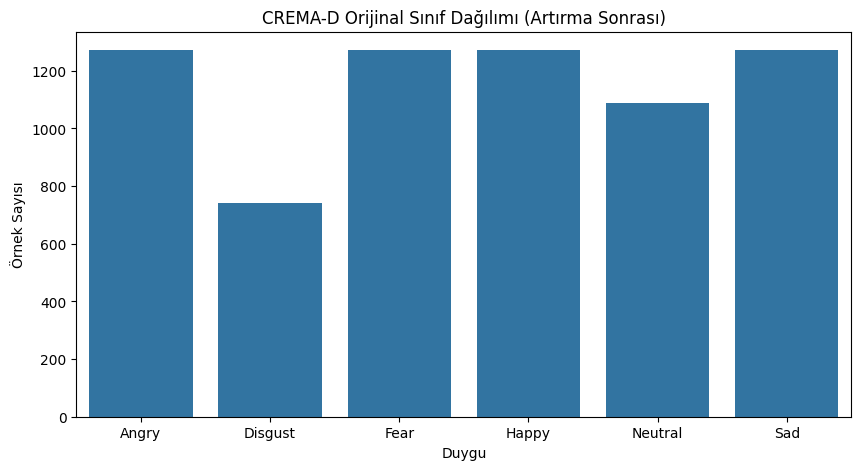

CREMA-D - SMOTE sonrası eğitim seti boyutu: (6102, 40)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 6102, number of used features: 40
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
CREMA-D - Seçilen öznitelik sayısı: 30


<Figure size 1200x800 with 0 Axes>

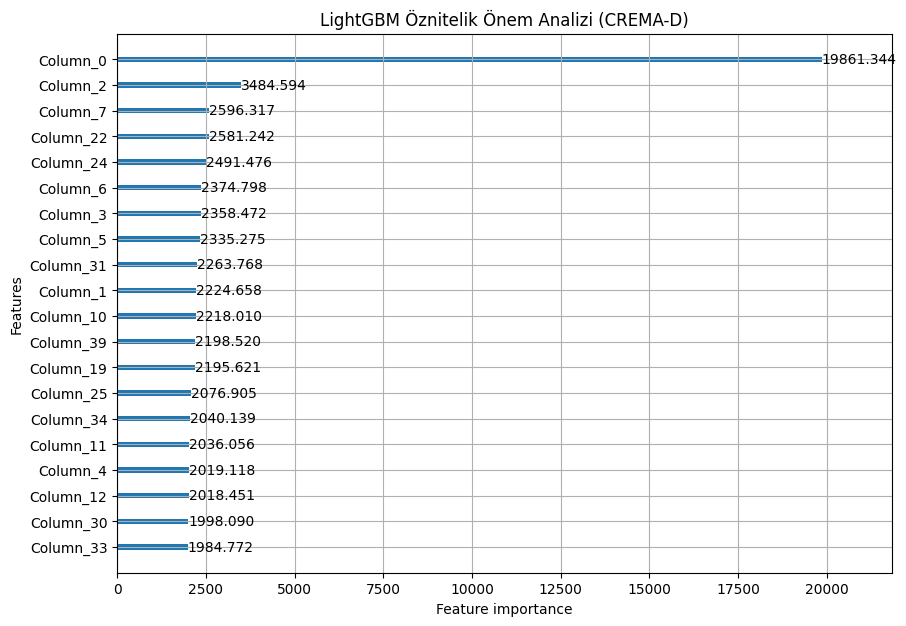

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 6102, number of used features: 30
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
--- LightGBM (CREMA-D) Doğrulama Sonuçları ---
Accuracy: 0.3980
Precision: 0.3901
Recall: 0.3980
F1-Score: 0.3900

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.54      0.63      0.58       127
     Disgust       0.23      0.20      0.22        74
        Fear       0.40      0.30      0.34       127
       Happy       0.32      0.2

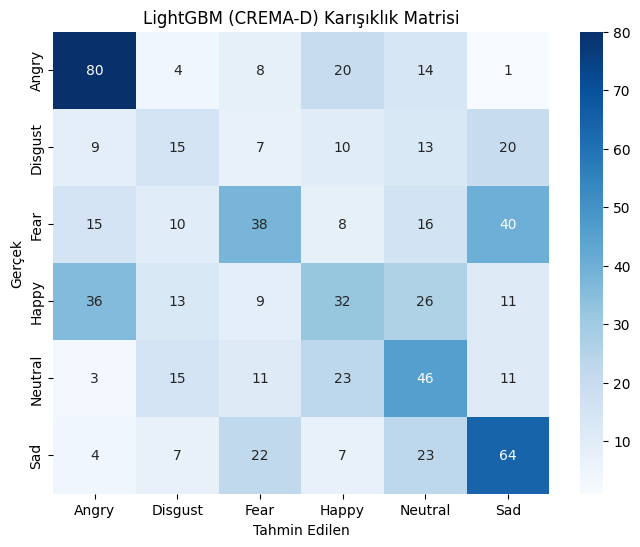

--- SVM (CREMA-D) Doğrulama Sonuçları ---
Accuracy: 0.3980
Precision: 0.3837
Recall: 0.3980
F1-Score: 0.3859

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.48      0.69      0.56       127
     Disgust       0.19      0.11      0.14        74
        Fear       0.34      0.35      0.34       127
       Happy       0.34      0.35      0.34       127
     Neutral       0.33      0.29      0.31       109
         Sad       0.53      0.47      0.50       127

    accuracy                           0.40       691
   macro avg       0.37      0.38      0.37       691
weighted avg       0.38      0.40      0.39       691



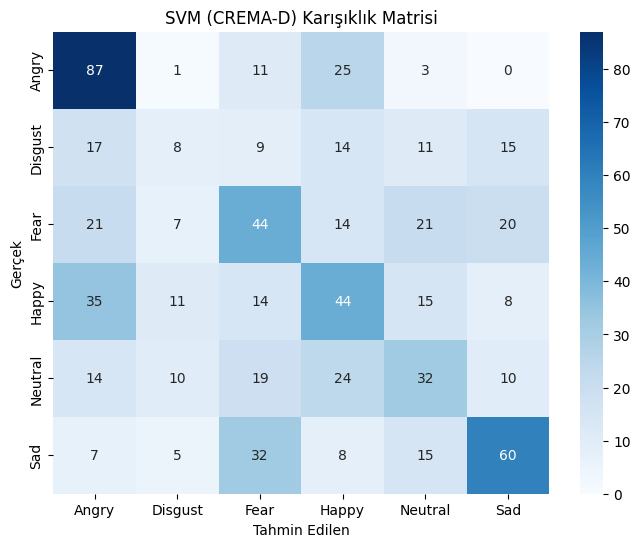

--- MLP (CREMA-D) Doğrulama Sonuçları ---
Accuracy: 0.3835
Precision: 0.3845
Recall: 0.3835
F1-Score: 0.3827

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.52      0.57      0.54       127
     Disgust       0.20      0.19      0.19        74
        Fear       0.32      0.33      0.33       127
       Happy       0.36      0.31      0.34       127
     Neutral       0.33      0.39      0.35       109
         Sad       0.50      0.43      0.46       127

    accuracy                           0.38       691
   macro avg       0.37      0.37      0.37       691
weighted avg       0.38      0.38      0.38       691



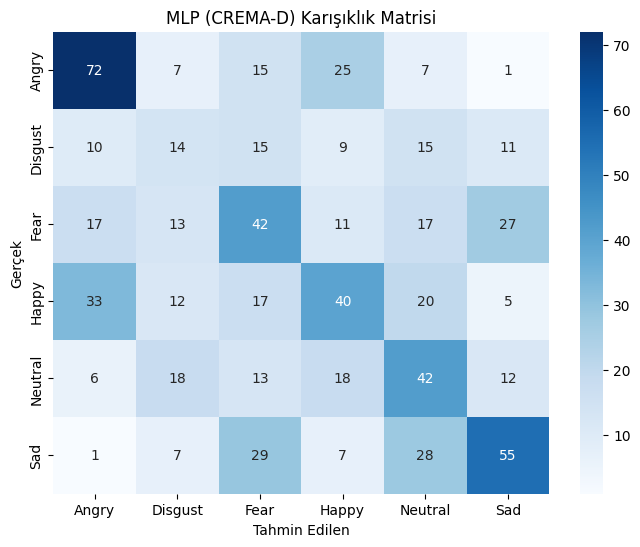


==================== CREMA-D_AUG VERİ SETİ İŞLENİYOR ====================
CREMA-D_AUG - Orijinal öznitelik boyutu: 61
CREMA-D_AUG - PCA sonrası öznitelik boyutu: 41


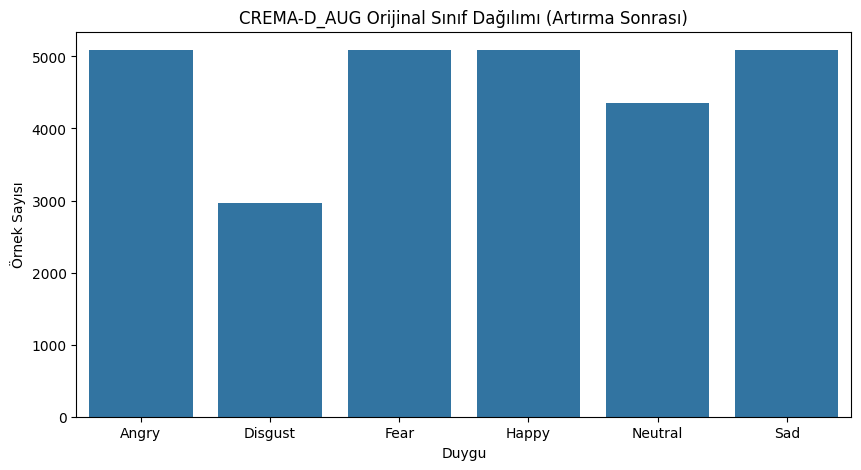

CREMA-D_AUG - SMOTE sonrası eğitim seti boyutu: (24420, 41)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 24420, number of used features: 41
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
CREMA-D_AUG - Seçilen öznitelik sayısı: 30


<Figure size 1200x800 with 0 Axes>

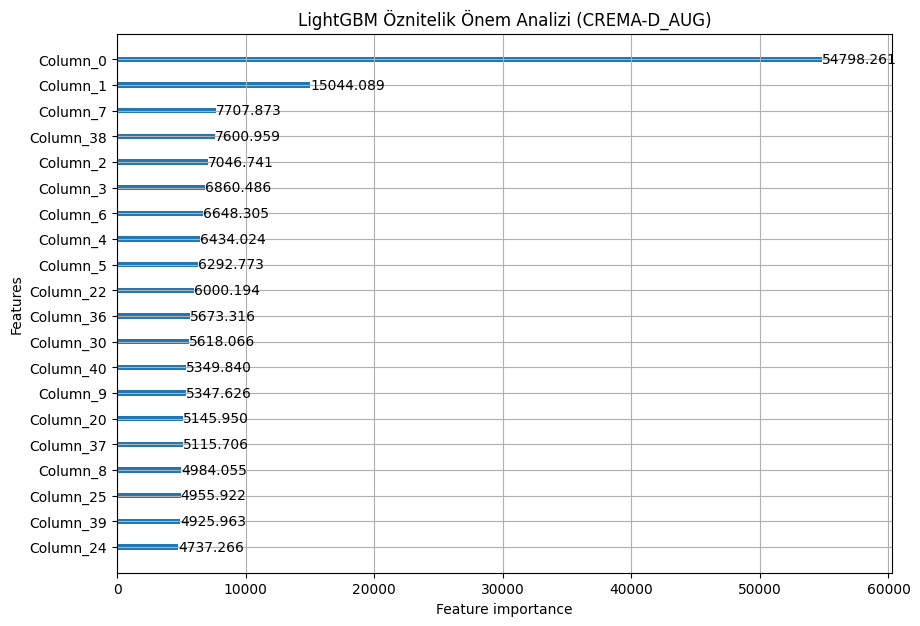

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 24420, number of used features: 30
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
--- LightGBM (CREMA-D_AUG) Doğrulama Sonuçları ---
Accuracy: 0.5029
Precision: 0.4990
Recall: 0.5029
F1-Score: 0.4950

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.62      0.75      0.68       508
     Disgust       0.29      0.25      0.27       297
        Fear       0.55      0.36      0.44       508
       Happy       0.44    

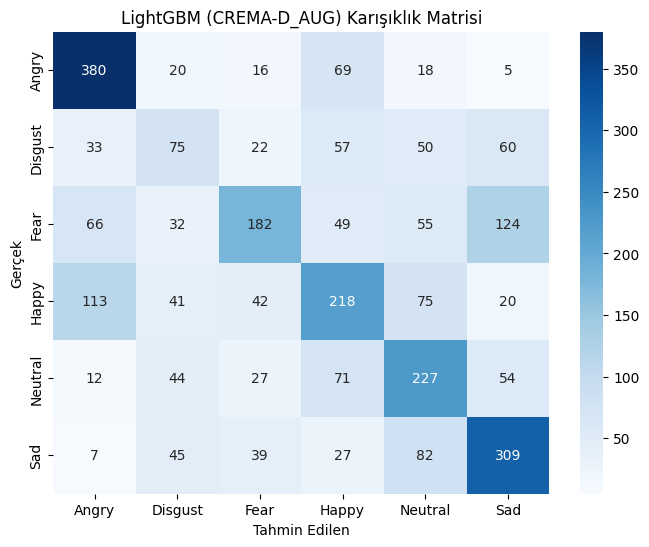

--- SVM (CREMA-D_AUG) Doğrulama Sonuçları ---
Accuracy: 0.6598
Precision: 0.6562
Recall: 0.6598
F1-Score: 0.6562

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.71      0.86      0.78       508
     Disgust       0.55      0.48      0.51       297
        Fear       0.65      0.59      0.62       508
       Happy       0.66      0.65      0.66       509
     Neutral       0.64      0.63      0.63       435
         Sad       0.68      0.66      0.67       509

    accuracy                           0.66      2766
   macro avg       0.65      0.65      0.65      2766
weighted avg       0.66      0.66      0.66      2766



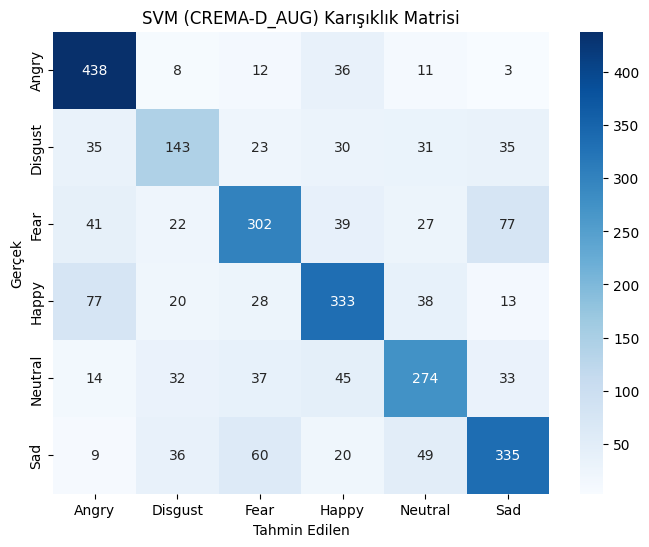

--- MLP (CREMA-D_AUG) Doğrulama Sonuçları ---
Accuracy: 0.5116
Precision: 0.5165
Recall: 0.5116
F1-Score: 0.5108

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.66      0.71      0.68       508
     Disgust       0.35      0.44      0.39       297
        Fear       0.53      0.39      0.45       508
       Happy       0.48      0.50      0.49       509
     Neutral       0.46      0.49      0.48       435
         Sad       0.55      0.50      0.52       509

    accuracy                           0.51      2766
   macro avg       0.50      0.51      0.50      2766
weighted avg       0.52      0.51      0.51      2766



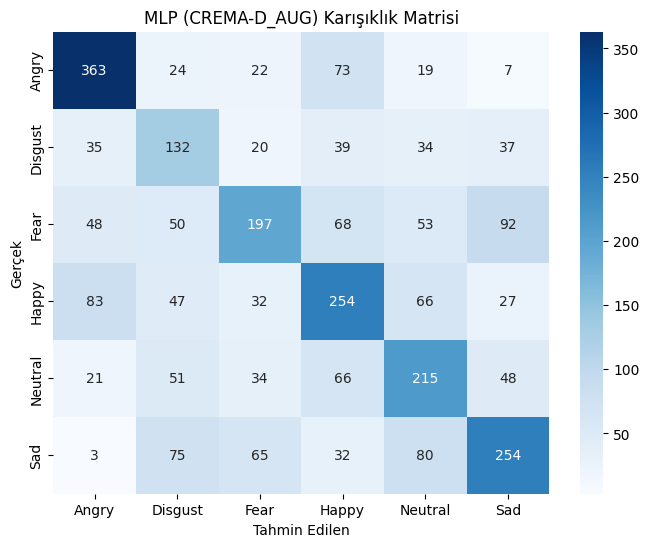


==================== EMO-DB VERİ SETİ İŞLENİYOR ====================
EMO-DB - Orijinal öznitelik boyutu: 61
EMO-DB - PCA sonrası öznitelik boyutu: 39


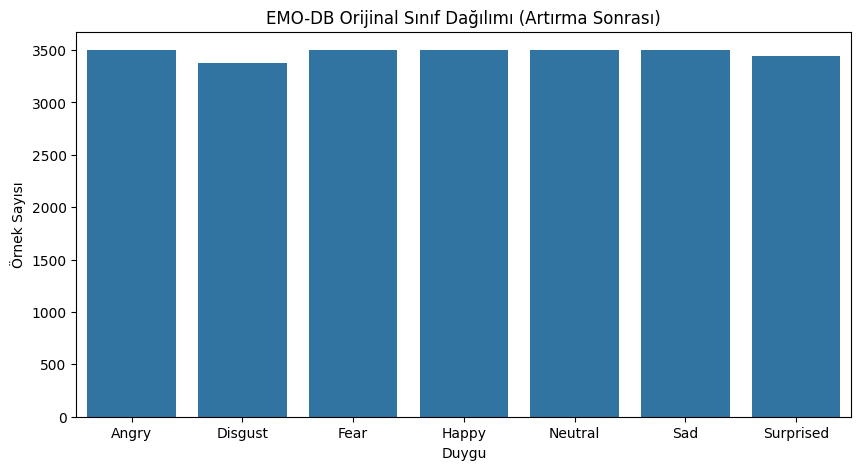

EMO-DB - SMOTE sonrası eğitim seti boyutu: (19600, 39)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 19600, number of used features: 39
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
EMO-DB - Seçilen öznitelik sayısı: 30


<Figure size 1200x800 with 0 Axes>

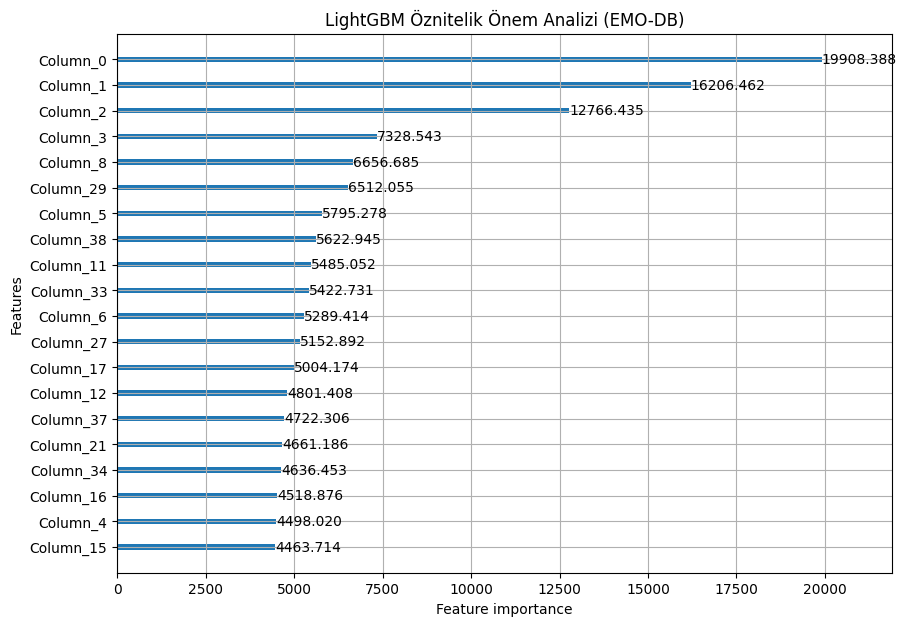

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 19600, number of used features: 30
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
--- LightGBM (EMO-DB) Doğrulama Sonuçları ---
Accuracy: 0.3531
Precision: 0.3448
Recall: 0.3531
F1-Score: 0.3434

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.33      0.33      0.33       350
     Disgust       0.29      0.18      0.22       338
        Fear       0.37      0.3

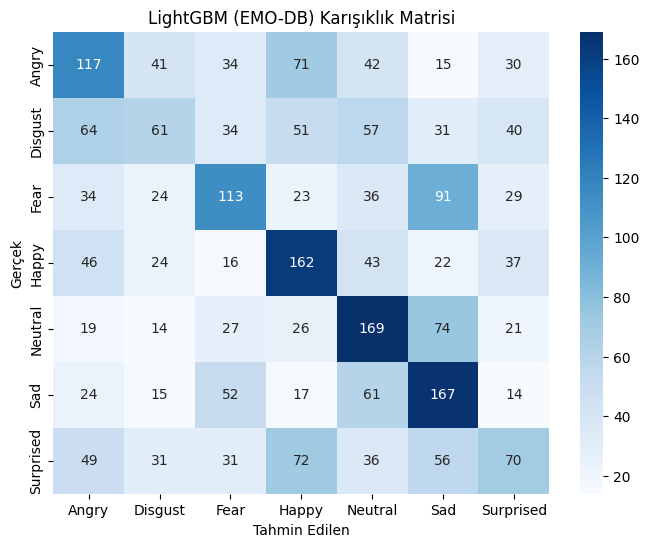

--- SVM (EMO-DB) Doğrulama Sonuçları ---
Accuracy: 0.3502
Precision: 0.3442
Recall: 0.3502
F1-Score: 0.3456

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.32      0.35      0.33       350
     Disgust       0.28      0.23      0.25       338
        Fear       0.34      0.32      0.33       350
       Happy       0.37      0.44      0.40       350
     Neutral       0.47      0.49      0.48       350
         Sad       0.38      0.41      0.40       350
   Surprised       0.25      0.20      0.22       345

    accuracy                           0.35      2433
   macro avg       0.34      0.35      0.34      2433
weighted avg       0.34      0.35      0.35      2433



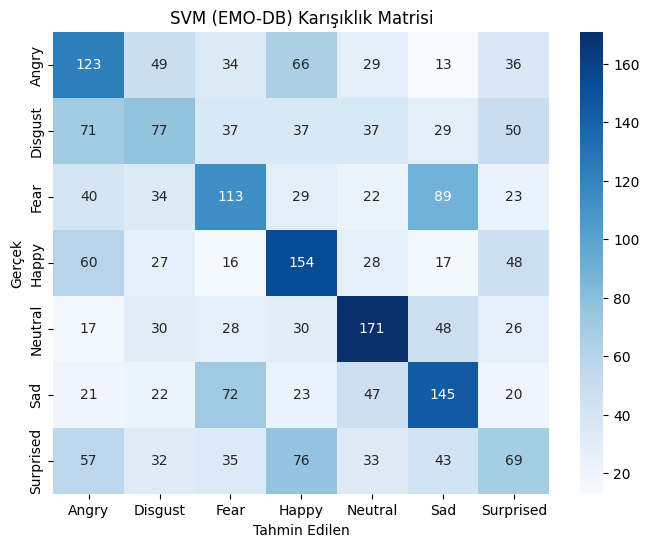

--- MLP (EMO-DB) Doğrulama Sonuçları ---
Accuracy: 0.3637
Precision: 0.3587
Recall: 0.3637
F1-Score: 0.3537

Sınıf Bazlı Performans:
              precision    recall  f1-score   support

       Angry       0.33      0.39      0.36       350
     Disgust       0.33      0.16      0.22       338
        Fear       0.35      0.27      0.30       350
       Happy       0.38      0.45      0.41       350
     Neutral       0.43      0.49      0.46       350
         Sad       0.38      0.51      0.43       350
   Surprised       0.30      0.28      0.29       345

    accuracy                           0.36      2433
   macro avg       0.36      0.36      0.35      2433
weighted avg       0.36      0.36      0.35      2433



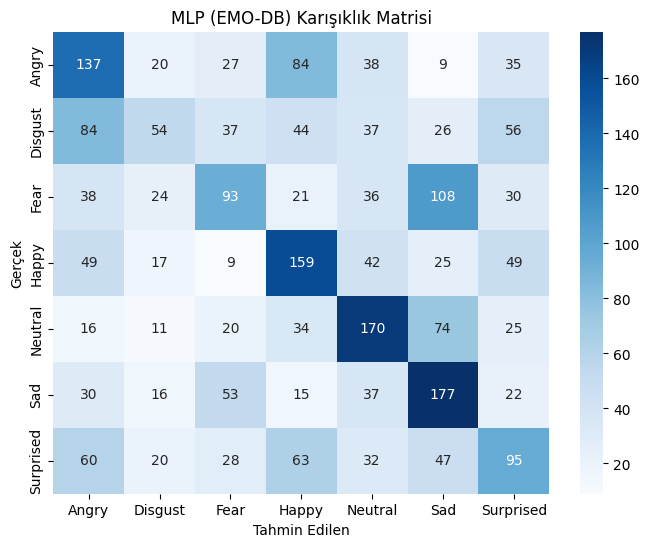

In [27]:
# Ana döngü
results = []
datasets_to_process = [
    ('CREMA-D', crema_features, crema_labels),
    ('CREMA-D_AUG', aug_crema_features, aug_crema_labels),
    ('EMO-DB', emodb_features, emodb_labels)
]

for dataset_name, features, labels in datasets_to_process:
    if features.size == 0:
        print(f"\n{dataset_name} veri seti atlanıyor çünkü hiç örnek yüklenemedi.")
        continue

    print(f"\n{'='*20} {dataset_name} VERİ SETİ İŞLENİYOR {'='*20}")
    X_train_sel, y_train_bal, X_val_sel, y_val, X_test_sel, y_test, le = process_dataset(features, labels, dataset_name)
    joblib.dump(le, f'/content/drive/MyDrive/AudioEmotionDetection/label_encoder_{dataset_name}.pkl')

    # --- LightGBM ---
    lgbm = lgb.LGBMClassifier(random_state=42)
    lgbm.fit(X_train_sel, y_train_bal, eval_set=[(X_val_sel, y_val)], callbacks=[lgb.early_stopping(10, verbose=False)])
    lgbm_acc, lgbm_f1, lgbm_precision, lgbm_recall = evaluate_model(lgbm, X_val_sel, y_val, 'LightGBM', dataset_name, le)
    joblib.dump(lgbm, f'/content/drive/MyDrive/AudioEmotionDetection/lgbm_model_{dataset_name}.pkl')

    # --- SVM ---
    # Hiperparametre optimizasyonu için daha küçük bir alt küme kullandık
    param_dist = {'C': loguniform(0.1, 100), 'gamma': loguniform(0.001, 1)}
    grid = RandomizedSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True),
                              param_distributions=param_dist, n_iter=5, cv=3, n_jobs=-1, random_state=42)
    grid.fit(X_train_sel, y_train_bal)
    svm = grid.best_estimator_
    svm_acc, svm_f1, svm_precision, svm_recall = evaluate_model(svm, X_val_sel, y_val, 'SVM', dataset_name, le)
    joblib.dump(svm, f'/content/drive/MyDrive/AudioEmotionDetection/svm_model_{dataset_name}.pkl')

    # --- MLP ---
    mlp = MLPClassifier(hidden_layer_sizes=(128, 64), alpha=0.001, learning_rate_init=0.001, max_iter=1000,
                        solver='adam', random_state=42, early_stopping=True, validation_fraction=0.1)
    mlp.fit(X_train_sel, y_train_bal)
    mlp_acc, mlp_f1, mlp_precision, mlp_recall = evaluate_model(mlp, X_val_sel, y_val, 'MLP', dataset_name, le)
    joblib.dump(mlp, f'/content/drive/MyDrive/AudioEmotionDetection/mlp_model_{dataset_name}.pkl')

    # Test verisini daha sonra kullanmak üzere kaydet
    np.save(f'/content/drive/MyDrive/AudioEmotionDetection/X_test_selected_{dataset_name}.npy', X_test_sel)
    np.save(f'/content/drive/MyDrive/AudioEmotionDetection/y_test_{dataset_name}.npy', y_test)

    results.append({
        'Model': ['LightGBM', 'SVM', 'MLP'],
        'Accuracy': [lgbm_acc, svm_acc, mlp_acc],
        'F1-Score': [lgbm_f1, svm_f1, mlp_f1],
        'Precision': [lgbm_precision, svm_precision, mlp_precision],
        'Recall': [lgbm_recall, svm_recall, mlp_recall],
        'Dataset': [dataset_name] * 3
    })

## 5. Sonuçların Karşılaştırılması
Tüm modellerin ve veri setlerinin performans metrikleri bir araya getirilerek toplu bir şekilde görselleştirilir. Bu, hangi modelin hangi veri setinde daha başarılı olduğunu anlamayı kolaylaştırır.

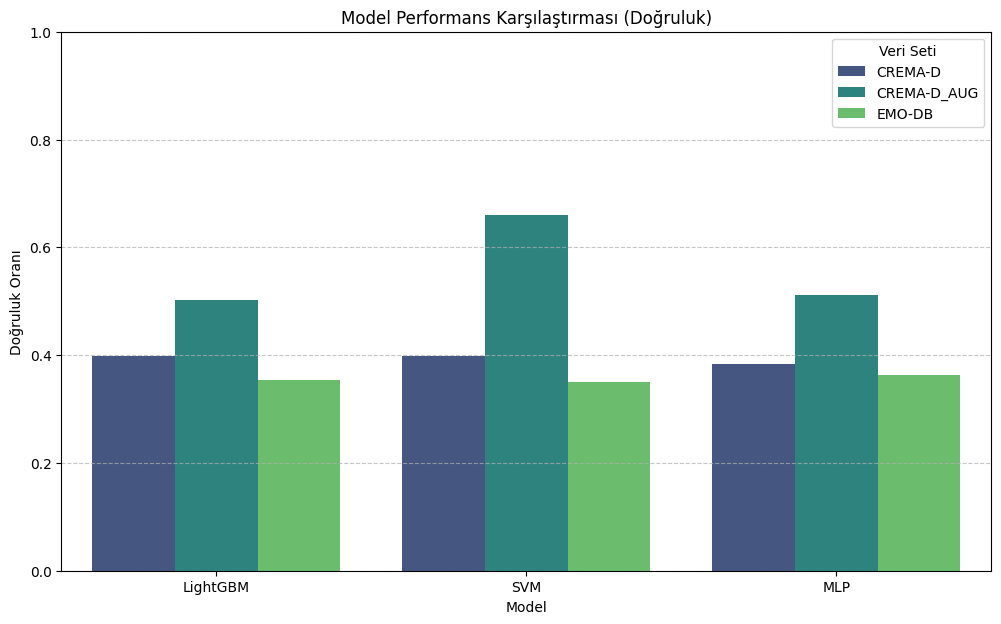

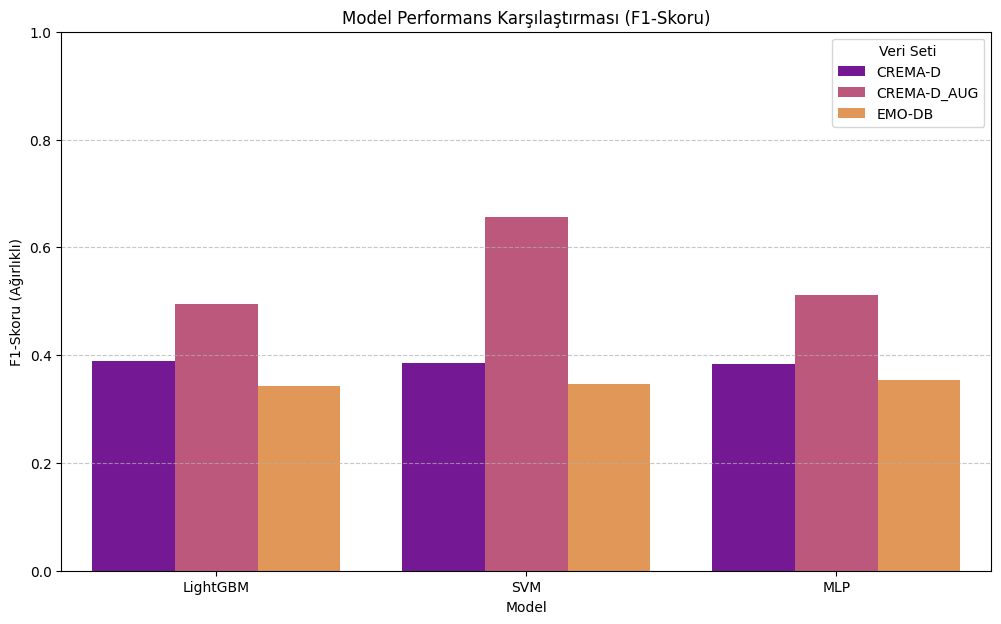

In [28]:
if results:
    results_df = pd.concat([pd.DataFrame(r) for r in results], ignore_index=True)

    # Doğruluk (Accuracy) Karşılaştırması
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=results_df, palette='viridis')
    plt.title('Model Performans Karşılaştırması (Doğruluk)')
    plt.ylabel('Doğruluk Oranı')
    plt.xlabel('Model')
    plt.legend(title='Veri Seti')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # F1-Skoru Karşılaştırması
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Model', y='F1-Score', hue='Dataset', data=results_df, palette='plasma')
    plt.title('Model Performans Karşılaştırması (F1-Skoru)')
    plt.ylabel('F1-Skoru (Ağırlıklı)')
    plt.xlabel('Model')
    plt.legend(title='Veri Seti')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Karşılaştırılacak sonuç bulunamadı. Lütfen önceki hücrelerin doğru çalıştığından emin olun.")
